In [1]:
import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate
import matplotlib.pyplot as plt
import numpy as np
import figurefirst

In [2]:
# simulation parameters

# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.2]

# time step and time series length
dt = 0.01
timeseries_length = 4 # steps

# Compare linear model to un-augmented methods

In [6]:
def plot_comparison(ax_dxdt, noise_level, optimize=True):
    # simulate
    x, x_truth, dxdt_truth, h, u = simulate.pi_control(dt=dt,
                                                       timeseries_length=timeseries_length,
                                                       noise_type=noise_type, 
                                                       noise_parameters=[0, noise_level])
    t = np.arange(0,len(dxdt_truth))*dt
    
    # linearmodel
    params = [3, 1e-6, 1e-1, 50]
    x_hat, dxdt_hat = pynumdiff.augmented_data.linearmodel(x, [u, h], dt, params, options={'smooth': True})
    ax_dxdt.plot(t, dxdt_hat, color='red')
    ax_dxdt.plot(t, dxdt_truth, '--', color='black')
    
    rms_rec_x, rms_x, rms_model = evaluate.metrics(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)
    print('RMS error in velocity: ', rms_model)
    
    # TVRj
    if optimize:
        params, val = pynumdiff.optimize.total_variation_regularization.jerk(x, dt, params=None, 
                                                                         tvgamma=0,
                                                                        dxdt_truth=dxdt_truth)
    else:
        params = [31]
    print('TVRj Optimal parameters: ', params)
    x_hat, dxdt_hat = pynumdiff.total_variation_regularization.jerk(x, dt, params)
    ax_dxdt.plot(t, dxdt_hat, color='purple', zorder=-5)
    
    rms_rec_x, rms_x, rms_tvrj = evaluate.metrics(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)
    print('RMS error in velocity: ', rms_tvrj)
    
    # SavGolDiff
    if optimize:
        params, val = pynumdiff.optimize.linear_model.savgoldiff(x, dt, params=None, options={'smooth': True}, 
                                                                 tvgamma=0,
                                                                 dxdt_truth=dxdt_truth)
    else:
        params = [3, 22]
    print('SavGolDiff Optimal parameters: ', params)
    x_hat, dxdt_hat = pynumdiff.linear_model.savgoldiff(x, dt, params, options={'smooth': True})
    ax_dxdt.plot(t, dxdt_hat, color='blue', zorder=-10)
    
    rms_rec_x, rms_x, rms_savgol = evaluate.metrics(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)
    print('RMS error in velocity: ', rms_savgol)
    print('--------------')
    
    return rms_model, rms_tvrj, rms_savgol

In [7]:
# plot dxdt estimates

RMS error in velocity:  0.020464847670531913
TVRj Optimal parameters:  [73.4375]
RMS error in velocity:  0.01893993974263339
SavGolDiff Optimal parameters:  [6, 55]
RMS error in velocity:  0.023512242670706052
--------------
RMS error in velocity:  0.047011489059767576
TVRj Optimal parameters:  [695.0]
RMS error in velocity:  0.09176596445110691
SavGolDiff Optimal parameters:  [1, 130]
RMS error in velocity:  0.07434660501446105
--------------
RMS error in velocity:  0.11358497283417408
TVRj Optimal parameters:  [1571.875]
RMS error in velocity:  0.1857768387582437
SavGolDiff Optimal parameters:  [1, 133]
RMS error in velocity:  0.07890504691136616
--------------


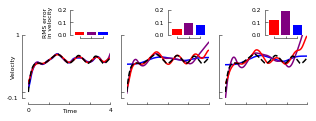

In [9]:
noise_levels = [0.01, 0.1, 0.2]

fig = plt.figure(figsize=(5,1.75))
plt.subplots_adjust(top=0.7, bottom=0.2)
xlim = [0, 4]
ylim=[-.1, 1]
spines=['left','bottom']

for i in range(len(noise_levels)):
    ax_dxdt = fig.add_subplot(1,len(noise_levels), i+1)
    rms_model, rms_tvrj, rms_savgol = plot_comparison(ax_dxdt, noise_levels[i])
    
    # format plot
    t = np.arange(0,int(timeseries_length/dt))*dt
    if xlim is None:
        xlim = [0, t[-1]]
    
    if i == 0:
        ticklabels = ['left', 'bottom']
    else:
        ticklabels = []
        
    ax_dxdt.set_xlim(xlim[0], xlim[-1])
    ax_dxdt.set_ylim(ylim[0], ylim[-1])
        
    xticks = [0, 1, 2, 3, 4]
    yticks = [ylim[0], 0, ylim[-1]]
    spine_locations = {spine: 6 for spine in spines}
    figurefirst.mpl_functions.adjust_spines(ax_dxdt, spines, xticks=xticks, yticks=yticks, spine_locations=spine_locations, tick_length=2.5, linewidth=0.5)

    if 'left' not in ticklabels:
        ax_dxdt.set_yticklabels(['', '', '', '', ''])
    else:
        ax_dxdt.set_yticklabels([str(ylim[0]), '', str(ylim[-1])])
        ax_dxdt.set_ylabel('Velocity')
        ax_dxdt.yaxis.labelpad = -9

    if 'bottom' not in ticklabels:
        ax_dxdt.set_xticklabels(['', '', '', '', ''])
    else:
        ax_dxdt.set_xticklabels(['0', '', '', '', '4'])
        ax_dxdt.set_xlabel('Time')
        ax_dxdt.xaxis.labelpad = -3.5

    # plot errors
    ax = fig.add_axes([0.25+i*0.27, 0.7, 0.1, 0.2])
    ax.bar(0, rms_model, width=0.8, color='red')
    ax.bar(1, rms_tvrj, width=0.8, color='purple')
    ax.bar(2, rms_savgol, width=0.8, color='blue')
    ax.set_ylim(0,0.2)
    figurefirst.mpl_functions.adjust_spines(ax, ['left', 'bottom'], xticks=[0,1,2], yticks=[0, 0.1, 0.2], 
                                            spine_locations= {spine: 3 for spine in ['left', 'bottom']}, 
                                            tick_length=2.5, linewidth=0.5)
    ax.set_xticklabels(['','',''])
    if i == 0:
        ax.set_ylabel('RMS error\nin velocity')
    
figurefirst.mpl_functions.set_fontsize(ax_dxdt.figure, 6)
    
fig.savefig('../figures/fig_augmenteddata_linearmodel.pdf')

# Plot noisy measurements

In [ ]:
noise_levels = [0.01, 0.1, 0.2]

fig = plt.figure(figsize=(5,1.5))
xlim = [0, 4]
ylim=[-.1, 2]
spines=['left','bottom']

for i in range(len(noise_levels)):
    ax_x = fig.add_subplot(1,len(noise_levels), i+1)
    # simulate
    x, x_truth, dxdt_truth, h, u = simulate.pi_control(dt=dt,
                                                       timeseries_length=timeseries_length,
                                                       noise_type=noise_type, 
                                                       noise_parameters=[0, noise_levels[i]])
    t = np.arange(0,len(dxdt_truth))*dt
    
    ax_x.plot(t, x, 'o', color='blue', zorder=-100, markersize=0.5)
    ax_x.plot(t, x_truth, '--', color='black', linewidth=0.5)
    
    # format plot
    t = np.arange(0,len(dxdt_truth))*dt
    if xlim is None:
        xlim = [0, t[-1]]
    
    if i == 0:
        ticklabels = ['left', 'bottom']
    else:
        ticklabels = []
        
    ax_x.set_xlim(xlim[0], xlim[-1])
    ax_x.set_ylim(ylim[0], ylim[-1])
        
    xticks = [0, 1, 2, 3, 4]
    yticks = [0, 1, 2]
    spine_locations = {spine: 6 for spine in spines}
    figurefirst.mpl_functions.adjust_spines(ax_x, spines, xticks=xticks, yticks=yticks, spine_locations=spine_locations, tick_length=2.5, linewidth=0.5)

    if 'left' not in ticklabels:
        ax_x.set_yticklabels(['', '', '', '', ''])
    else:
        ax_x.set_yticklabels([str(ylim[0]), '', str(ylim[-1])])
        ax_x.set_ylabel('Velocity')
        ax_x.yaxis.labelpad = -9

    if 'bottom' not in ticklabels:
        ax_x.set_xticklabels(['', '', '', '', ''])
    else:
        ax_x.set_xticklabels(['0', '', '', '', '4'])
        ax_x.set_xlabel('Time')
        ax_x.xaxis.labelpad = -3.5

    figurefirst.mpl_functions.set_fontsize(ax_x.figure, 6)
    plt.tight_layout()
    
fig.savefig('../figures/fig_augmenteddata_linearmodel_pos.pdf')